# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/datasets/ealaxi/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [1]:
import pandas as pd
import numpy as np
import imblearn
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [4]:
financial_data = pd.read_csv(r"C:\Users\dulce\Downloads\archive (1)\PS_20174392719_1491204439457_log.csv").sample(n = 100000)
financial_data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
736176,38,PAYMENT,7959.38,C2126805508,26952.00,18992.62,M1898089637,0.00,0.00,0,0
4402373,321,PAYMENT,26463.20,C674711351,0.00,0.00,M1322840643,0.00,0.00,0,0
1900270,165,CASH_IN,156967.14,C95679624,51743.00,208710.14,C468652831,438548.78,281581.65,0,0
5401590,377,PAYMENT,35654.03,C781169667,0.00,0.00,M1783548772,0.00,0.00,0,0
3964088,297,PAYMENT,33506.29,C691264809,62007.00,28500.71,M632076351,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
5785565,400,CASH_OUT,154633.65,C1929566219,0.00,0.00,C1520472655,185745.48,340379.13,0,0
6127999,542,CASH_OUT,23859.86,C613398830,9482.00,0.00,C143665280,12716259.38,12740119.25,0,0
1122963,130,CASH_IN,452641.53,C320077420,7865861.33,8318502.86,C303956982,760849.95,308208.42,0,0
55531,9,CASH_OUT,157537.88,C2098030400,594832.47,437294.59,C222581384,0.00,347710.24,0,0


In [5]:
print(financial_data.describe())

                step        amount  oldbalanceOrg  newbalanceOrig  \
count  100000.000000  1.000000e+05   1.000000e+05    1.000000e+05   
mean      243.062430  1.843948e+05   8.320349e+05    8.531603e+05   
std       142.303386  6.734997e+05   2.883308e+06    2.918311e+06   
min         1.000000  1.600000e-01   0.000000e+00    0.000000e+00   
25%       155.000000  1.331933e+04   0.000000e+00    0.000000e+00   
50%       238.000000  7.506494e+04   1.385339e+04    0.000000e+00   
75%       335.000000  2.095494e+05   1.067000e+05    1.445242e+05   
max       741.000000  7.117248e+07   3.729746e+07    3.753800e+07   

       oldbalanceDest  newbalanceDest        isFraud  isFlaggedFraud  
count    1.000000e+05    1.000000e+05  100000.000000        100000.0  
mean     1.094580e+06    1.226624e+06       0.001250             0.0  
std      3.494292e+06    3.868588e+06       0.035333             0.0  
min      0.000000e+00    0.000000e+00       0.000000             0.0  
25%      0.000000e+00  

In [20]:
financial_data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [15]:
financial_data.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [19]:
missing_values = financial_data.isnull().sum()
missing_values

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

C:\Users\dulce\AppData\Local\Temp\ipykernel_16748\862492489.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = financial_data.corr()


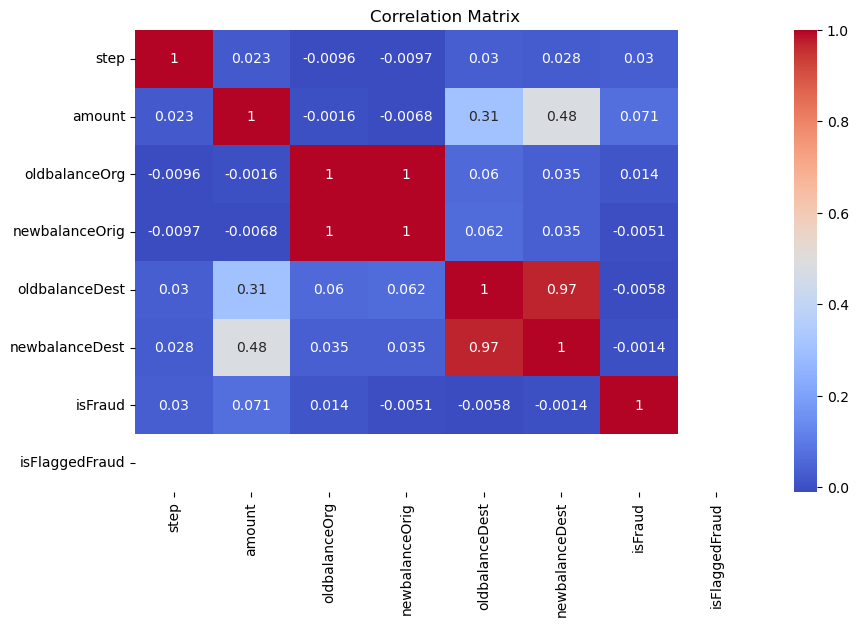

In [12]:
# Understanding the Correlatio

correlation_matrix = financial_data.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### What is the distribution of the outcome? 

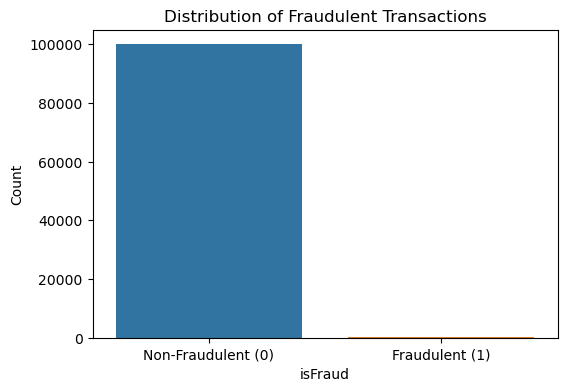

In [21]:
fraud_distribution = financial_data['isFraud'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=fraud_distribution.index, y=fraud_distribution.values)
plt.title('Distribution of Fraudulent Transactions')
plt.xlabel('isFraud')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Fraudulent (0)', 'Fraudulent (1)'])
plt.show()

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [22]:
financial_data_cleaned = financial_data.dropna()

In [23]:
financial_data_cleaned['timestamp'] = pd.to_datetime(financial_data_cleaned['step'] * 3600, unit='s')

financial_data_cleaned['time_since_last_transaction'] = financial_data_cleaned.groupby('nameOrig')['timestamp'].diff().dt.total_seconds().fillna(0)

In [37]:
column_name_mapping = {
    'step': 'Time_step',
    'type': 'Transaction_type',
    'amount': 'Transaction_amount',
    'nameOrig': 'Sender_account_name',
    'oldbalanceOrg': 'Sender_starting_balance',
    'newbalanceOrig': 'Sender_ending_balance',
    'nameDest': 'Destinatary_account_name',
    'oldbalanceDest': 'Destinatary_starting_balance',
    'newbalanceDest': 'Destinatary_ending_balance',
    'isFraud': 'Fraudulent_transaction',
    'isFlaggedFraud': 'Flagged_as_fraud'
}

financial_data_cleaned.rename(columns=column_name_mapping, inplace=True)

In [38]:
financial_data_cleaned.to_csv('cleaned_financial_data.csv', index = False)

### Run a logisitc regression classifier and evaluate its accuracy.

In [40]:
X = financial_data_cleaned[['Transaction_amount', 'Sender_starting_balance', 'Sender_ending_balance']]
y = financial_data_cleaned['Fraudulent_transaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print('Confusion Matrix:')
print(confusion)
print('\nClassification Report:')
print(report)

Accuracy: 1.00
Confusion Matrix:
[[19944    33]
 [    0    23]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19977
           1       0.41      1.00      0.58        23

    accuracy                           1.00     20000
   macro avg       0.71      1.00      0.79     20000
weighted avg       1.00      1.00      1.00     20000



### Now pick a model of your choice and evaluate its accuracy.

In [42]:
from sklearn.svm import SVC

X = financial_data_cleaned[['Transaction_amount', 'Sender_starting_balance', 'Sender_ending_balance']]
y = financial_data_cleaned['Fraudulent_transaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

model = SVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print('Confusion Matrix:')
print(confusion)
print('\nClassification Report:')
print(report)

Accuracy: 1.00
Confusion Matrix:
[[19981     0]
 [   17     2]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19981
           1       1.00      0.11      0.19        19

    accuracy                           1.00     20000
   macro avg       1.00      0.55      0.60     20000
weighted avg       1.00      1.00      1.00     20000



In [43]:
from sklearn.ensemble import RandomForestClassifier

X = financial_data_cleaned[['Transaction_amount', 'Sender_starting_balance', 'Sender_ending_balance']]
y = financial_data_cleaned['Fraudulent_transaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print('Confusion Matrix:')
print(confusion)
print('\nClassification Report:')
print(report)

Accuracy: 1.00
Confusion Matrix:
[[19976     2]
 [   14     8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19978
           1       0.80      0.36      0.50        22

    accuracy                           1.00     20000
   macro avg       0.90      0.68      0.75     20000
weighted avg       1.00      1.00      1.00     20000



### Which model worked better and how do you know?

In [ ]:
# Seems like the Random Forest classifier performs better with a higher F1-score, precision, 
# and recall compared to the SVM. 

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.